## Lesson 5: Email Assistant with Semantic + Episodic + Procedural Memory

We previously built an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Uses human-in-the-loop to refine the assistant's ability to classify emails
- Drafts responses
- Schedules meetings
- Uses memory to remember details from previous emails 

Now, we'll add procedural memory that allows the user to `update instructions for using the calendar and email writing` tools. 

<!-- <p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px">  -->
🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

## Load API tokens for our 3rd party APIs

In [1]:
from dotenv import load_dotenv
print(load_dotenv())

True


## 1. Setup a Profile, Prompt and Example Email

In [2]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

📝 Notes:
- The system has a Triage prompt which is responsible for triaging the user's email into 3 different categories.
- We also have the instructions for the main agent. (This will be called after the system decides to response to an email)

* Note: These are separate from the rest of the prompt since they will be updated as part of the memory.

The goal of adding the `Procedural Memory` is to be able to update the following instructions over time.

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

**Example email to see the schema of what we will be working with**

In [4]:
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

### Define 🛠️ tools for managing memory (semantic memory)

Prepare the vector database

In [5]:
from langgraph.store.memory import InMemoryStore

In [6]:
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-small"}
)
# ignore beta warning if it appears

c:\Users\farza\anaconda3\envs\memory-env\Lib\site-packages\langgraph\store\base\embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


**********************

# 🧠 Episodic Memory

Add few shot examples to InMemoryStore (Vector Database)

In [7]:
import uuid
# First Example
email = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}
data = {
    "email": email,
    # This is to start changing the behavior of the agent
    "label": "respond"
}

store.put(
    ("email_assistant", "lance", "examples"), 
    str(uuid.uuid4()), 
    data
)
# Second Example
data = {
    "email": {
        "author": "Sarah Chen <sarah.chen@company.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "Update: Backend API Changes Deployed to Staging",
        "email_thread": """Hi John,
    
    Just wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
    
    - Implemented JWT refresh token rotation
    - Added rate limiting for login attempts
    - Updated API documentation with new endpoints
    
    All tests are passing and the changes are ready for review. You can test it out at staging-api.company.com/auth/*
    
    No immediate action needed from your side - just keeping you in the loop since this affects the systems you're working on.
    
    Best regards,
    Sarah
    """,
    },
    "label": "ignore"
}
store.put(
    ("email_assistant", "lance", "examples"),
    str(uuid.uuid4()),
    data
)
print("Few Shot Examples were added to the vector database.")

Few Shot Examples were added to the vector database.


### Simulate searching and returning examples

This helper function will take in the few shot examples that are retrieved from the `store`  and format them nicely into a `string`. (It gives us better visibility on what was retrieved and also it will be a better format for the LLM)

In [8]:
# Template for formating an example to put in prompt
template = """Email Subject: {subject}
Email From: {from_email}
Email To: {to_email}
Email Content: 
```
{content}
```
> Triage Result: {result}"""

# Format list of few shots
def format_few_shot_examples(examples):
    strs = ["Here are some previous examples:"]
    for eg in examples:
        strs.append(
            template.format(
                subject=eg.value["email"]["subject"],
                to_email=eg.value["email"]["to"],
                from_email=eg.value["email"]["author"],
                content=eg.value["email"]["email_thread"][:400],
                result=eg.value["label"],
            )
        )
    return "\n\n------------\n\n".join(strs)

### Test the vector database by a sample search

Letr's use the same email that we passed above with a small change (removing `Just`) from the first line. This is a semantic search just like a simple RAG pipeline.

`limit = 1` just fetches the most similar email to the output.

In [9]:
email_data = {
        "author": "Sarah Chen <sarah.chen@company.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "Update: Backend API Changes Deployed to Staging",
        "email_thread": """Hi John,
    
    Wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
    
    - Implemented JWT refresh token rotation
    - Added rate limiting for login attempts
    - Updated API documentation with new endpoints
    
    All tests are passing and the changes are ready for review. You can test it out at staging-api.company.com/auth/*
    
    No immediate action needed from your side - just keeping you in the loop since this affects the systems you're working on.
    
    Best regards,
    Sarah
    """,
    }
results = store.search(
    ("email_assistant", "lance", "examples"),
    query=str({"email": email_data}),
    limit=1)
print(format_few_shot_examples(results))

Here are some previous examples:

------------

Email Subject: Update: Backend API Changes Deployed to Staging
Email From: Sarah Chen <sarah.chen@company.com>
Email To: John Doe <john.doe@company.com>
Email Content: 
```
Hi John,
    
    Just wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:
    
    - Implemented JWT refresh token rotation
    - Added rate limiting for login attempts
    - Updated API documentation with new endpoints
    
    All tests are passing and the changes are ready for review. You can test it out at st
```
> Triage Result: ignore


## 📝 Triage prompt

Pay attention to the structure of the prompt and different sections (user profile background, few shot examples, etc.)

In [10]:
triage_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >

Here are some examples of previous emails, and how they should be handled.
Follow these examples more than any instructions above

{examples}
</ Few shot examples >
"""

## Setup Routing Node

In [11]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [12]:
llm = init_chat_model("openai:gpt-4o-mini")

**Defining the schema that we want the Triage step to output**
- Reasoning: So the LLM give us the reason for making a decision.
- Classification

In [13]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

Now let's bind the Router to an LLM. This LLM will always return information in the schema that we defined above.

In [14]:
llm_router = llm.with_structured_output(Router)

### Load `triage_user_prompt`

**System prompt structure:**
1. Role: System role
2. Background: User profile background
3. Instructions: Explaining the 3 different categories that we want to classify the emails into
4. Rule: We will add different rules for the LLM to follow
5. Examples: To contain the few shot examples

**User prompt structure:**
It formats the email.

In [15]:
from prompts import triage_user_prompt

In [16]:
# uncomment to view
print(triage_system_prompt)
print(triage_user_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >

Here are some e

## Create the Overall Agent Using LangGraph

1. Define the State of the agent
    - email_input: It is what the user will pass in and will contain all the info about the email
    - messages: The messages for the agent's workflow

In [17]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

#### Setup Triage Router Node

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal

#### 2. Defining a Node for the Triage stept

Updated `triage_router` gets `ignore`, `notify` and `respond` rule from `store` and returns a command.

Note: Command will update the state and also it tells the agent where to go. Depending on the result of the triage step, The agent has two options to go after the triage node:
- response_agent
- end of the graph

We modify this function to retrieve prompt_instructions["triage_rules"] from the `store` and add them to the system prompt. Doing this we can update the rules of the agent without the need to modify the code.


- triage_router()

1. Inputs `store`, `config` and `store` arguemnts
2. Before the system prompt, we add the logic that adds the few shot example in there
    - Define the `namespace`
    - Use `namespace` to search in the store
    - format the search result
    - update the system prompt and add the formatted output

In [19]:
def triage_router(state: State, config, store) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']
    # ---------------Section for Episodic memory ----------------------
    namespace = (
        "email_assistant",
        config['configurable']['langgraph_user_id'],
        "examples"
    )
    examples = store.search(
        namespace, 
        query=str({"email": state['email_input']})
    )
    print("Examples:", examples)
    examples=format_few_shot_examples(examples)
    # ---------------End of Section for Episodic memory ---------------
    # -------------Section for Procedural Memory-----------------------
    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )
    # Let's get the `ingnore` rules from the store
    result = store.get(namespace, "triage_ignore")
    if result is None: # If it does not exist
        store.put(
            namespace, 
            "triage_ignore", 
            {"prompt": prompt_instructions["triage_rules"]["ignore"]}
        )
        ignore_prompt = prompt_instructions["triage_rules"]["ignore"]
    else: # If it exists
        ignore_prompt = result.value['prompt']
    # Let's get the `notify` rules from the store
    result = store.get(namespace, "triage_notify")
    if result is None:
        store.put(
            namespace, 
            "triage_notify", 
            {"prompt": prompt_instructions["triage_rules"]["notify"]}
        )
        notify_prompt = prompt_instructions["triage_rules"]["notify"]
    else:
        notify_prompt = result.value['prompt']
    # Let's get the `respond` rules from the store
    result = store.get(namespace, "triage_respond")
    if result is None:
        store.put(
            namespace, 
            "triage_respond", 
            {"prompt": prompt_instructions["triage_rules"]["respond"]}
        )
        respond_prompt = prompt_instructions["triage_rules"]["respond"]
    else:
        respond_prompt = result.value['prompt']
    
    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=ignore_prompt, # new way of passing the ignore rules to the prompt
        triage_notify=notify_prompt, # new way of passing the notify rules to the prompt
        triage_email=respond_prompt, # new way of passing the respond rules to the prompt
        examples=examples
    )
    # -------------End of Section for Procedural Memory---------------
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

## Build the rest of our agent

### 🛠️ Define Tools

In [20]:
from langchain_core.tools import tool

In [21]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"


**********************

# 🧠 Semantic Memory

In [22]:
from langmem import create_manage_memory_tool, create_search_memory_tool

`langgraph_user_id`: This will be passed to the tool as part of the runtime configuration. That will be used to namespace the memory so if we are dealing with emails for multiple users, we can easily handle it and have different collections for different users.

In [23]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

print(manage_memory_tool.name)
print(manage_memory_tool.description)
print(manage_memory_tool.args)
print("--------------")
print(search_memory_tool.name)
print(search_memory_tool.description)
print(search_memory_tool.args)

manage_memory
Create, update, or delete persistent MEMORIES to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.
{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Content'}, 'action': {'default': 'create', 'enum': ['create', 'update', 'delete'], 'title': 'Action', 'type': 'string'}, 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Id'}}
--------------
search_memory
Search your long-term memories for information relevant to your current context.
{'query': {'title': 'Query', 'type': 'string'}, 'limit': {'default': 10, 'title'

In [24]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

#### 📝 Updated create_prompt `gets prompt` from `store`

1. Add config and `store` arguments
2. Let's get the agent_instroctions from the `store`
3. Handle the scenario when there is no result

In [25]:
def create_prompt(state, config, store):
    langgraph_user_id = config['configurable']['langgraph_user_id']
    namespace = (langgraph_user_id, )
    result = store.get(namespace, "agent_instructions")
    if result is None:
        store.put(
            namespace, 
            "agent_instructions", 
            {"prompt": prompt_instructions["agent_instructions"]}
        )
        prompt = prompt_instructions["agent_instructions"]
    else:
        prompt = result.value['prompt']
    
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt, # before we had prompt_instructions["agent_instructions"]
                **profile
            )
        }
    ] + state['messages']

## 🎯 Create the email agent

In [26]:
from langgraph.prebuilt import create_react_agent

In [27]:
tools= [
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
response_agent = create_react_agent(
    "openai:gpt-4o",
    tools=tools,
    prompt=create_prompt,
    # Use this to ensure the store is passed to the agent 
    store=store
)

In [28]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

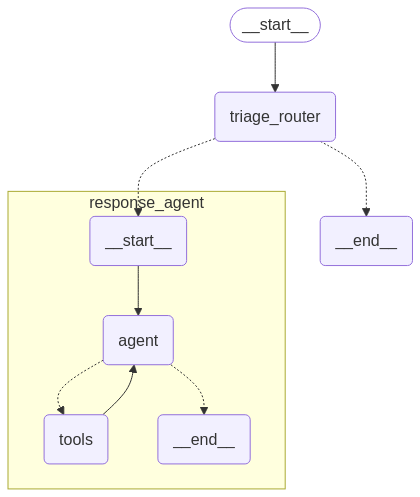

In [29]:
from IPython.display import Image, display

display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

### Setup Agent to update Long Term Memory in the background
Your `email_agent` is now setup to pull its instructions from long-term memory.  
Now, you'll create an agent to update that memory. First check current behavior.

In [30]:
config = {"configurable": {"langgraph_user_id": "lance"}}

In [31]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

Urgent issue - your service is down. Is there a reason why""",
}

In [32]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

Examples: [Item(namespace=['email_assistant', 'lance', 'examples'], key='c412ca40-966f-436f-83bf-1c3d02ddfdf3', value={'email': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}, 'label': 'respond'}, created_at='2025-04-21T03:20:06.355239+00:00', updated_at='2025-04-21T03:20:06.355239+00:00', score=0.7381088328932177), Item(namespace=['email_assistant', 'lance', 'examples'], key='5254af4c-d788-4804-bec6-16211cbd09e8', value={'email': {'author': 'Sarah Chen <sarah.chen@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Update: Backend API Changes De

In [33]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi John,\n\nUrgent issue - your service is down. Is there a reason why'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_U0iRMez5qGCJ6qUXtQjdPJti)
 Call ID: call_U0iRMez5qGCJ6qUXtQjdPJti
  Args:
    to: alice.jones@bar.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thanks for reaching out. I'm sorry to hear about the service issue. Let me look into it right away, and I'll get back to you as soon as possible with an update.

Best regards,

John
================================= Tool Message =================================
Name: write_email

Email sent to alice.jones@bar.com with subject 'Re: Quick question about API documentati


#### 🧠 Episodic Memory: Update store to ignore emails like this

In case we don't like the agents behavior for a specific email, we can add it to the few shot examples for further prompts.


**Test before changing the instructions**

In [34]:
email_input = {
    "author": "Tom Jones <tome.jones@bar.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John - want to buy documentation?""",
}

response = email_agent.invoke(
    {"email_input": email_input}, 
    config={"configurable": {"langgraph_user_id": "harrison"}}
)

Examples: []
📧 Classification: RESPOND - This email requires a response


In [35]:
data = {
    "email": {
    "author": "Tom Jones <tome.jones@bar.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John - want to buy documentation?""",
},
    "label": "notify"
}

store.put(
    ("email_assistant", "harrison", "examples"),
    str(uuid.uuid4()),
    data
)

In [36]:
email_input = {
    "author": "Tom Jones <tome.jones@bar.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John - want to buy documentation?""",
}

response = email_agent.invoke(
    {"email_input": email_input}, 
    config={"configurable": {"langgraph_user_id": "harrison"}}
)

Examples: [Item(namespace=['email_assistant', 'harrison', 'examples'], key='bfce07ed-da03-452c-a7a8-2de80e1af97d', value={'email': {'author': 'Tom Jones <tome.jones@bar.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi John - want to buy documentation?'}, 'label': 'notify'}, created_at='2025-04-21T03:20:17.818553+00:00', updated_at='2025-04-21T03:20:17.818553+00:00', score=0.9095306238246793)]
📧 Classification: RESPOND - This email requires a response


## Now let's update the system prompts

#### First let's have and look at current values of long term memory

In [37]:
print("agent_instructions:", store.get(("lance",), "agent_instructions").value['prompt'])
print("triage_respond:", store.get(("lance",), "triage_respond").value['prompt'])
print("triage_ignore:", store.get(("lance",), "triage_ignore").value['prompt'])
print("triage_notify:", store.get(("lance",), "triage_notify").value['prompt'])

agent_instructions: Use these tools when appropriate to help manage John's tasks efficiently.
triage_respond: Direct questions from team members, meeting requests, critical bug reports
triage_ignore: Marketing newsletters, spam emails, mass company announcements
triage_notify: Team member out sick, build system notifications, project status updates


### 🧠 Procedural Memory: Now, Use an LLM to update instructions based on the user feedback

In [38]:
from langmem import create_multi_prompt_optimizer

In [39]:
conversations = [
    (
        response['messages'],
        "Always sign your emails `John Doe`"
    )
]

Now we can define the prompt that we want to update. Each entry has 4 keys:
1. Name of the prompt
2. Value of the prompt
3. Update instructions that exaplains `how` the LLM should update the prompt
4. Update key that explains `when` the LLM should update the prompt

In [40]:
prompts = [
    {
        "name": "main_agent",
        "prompt": store.get(("lance",), "agent_instructions").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should write emails or schedule events"
        
    },
    {
        "name": "triage-ignore", 
        "prompt": store.get(("lance",), "triage_ignore").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"

    },
    {
        "name": "triage-notify", 
        "prompt": store.get(("lance",), "triage_notify").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails the user should be notified of"

    },
    {
        "name": "triage-respond", 
        "prompt": store.get(("lance",), "triage_respond").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be responded to"

    },
]

In [41]:
# Best model for this type of prompt optimization

# optimizer = create_multi_prompt_optimizer(
#     "anthropic:claude-3-5-sonnet-latest",
#     kind="prompt_memory",
# )

# For this video, I'll use openai
optimizer = create_multi_prompt_optimizer(
    "openai:gpt-4o",
    kind="prompt_memory",
)

`optimizer` is a graph so we can invoke it with the `trajectories` and `prompts` keys

In [42]:
updated = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)

In [43]:
from pprint import pprint
pprint(updated)

[{'name': 'main_agent',
  'prompt': "Use these tools when appropriate to help manage John's tasks "
            "efficiently. Always sign emails with 'John Doe'.",
  'update_instructions': 'keep the instructions short and to the point',
  'when_to_update': 'Update this prompt whenever there is feedback on how the '
                    'agent should write emails or schedule events'},
 {'name': 'triage-ignore',
  'prompt': 'Marketing newsletters, spam emails, mass company announcements',
  'update_instructions': 'keep the instructions short and to the point',
  'when_to_update': 'Update this prompt whenever there is feedback on which '
                    'emails should be ignored'},
 {'name': 'triage-notify',
  'prompt': 'Team member out sick, build system notifications, project status '
            'updates',
  'update_instructions': 'keep the instructions short and to the point',
  'when_to_update': 'Update this prompt whenever there is feedback on which '
                    'emails 

In [44]:
# json dumps is a bit easier to read
# import json
# print(json.dumps(updated, indent=4))

#### update the prompts in store. 
> ~~Note.. only one of the prompts was included here! The remainder are left to you!~~

In [45]:
for i, updated_prompt in enumerate(updated):
    old_prompt = prompts[i]
    if updated_prompt['prompt'] != old_prompt['prompt']:
        name = old_prompt['name']
        print(f"updated {name}")
        if name == "main_agent":
            store.put(
                ("lance",),
                "agent_instructions",
                {"prompt":updated_prompt['prompt']}
            )
        if name == "triage-ignore":
            store.put(
                ("lance",),
                "triage_ignore",
                {"prompt":updated_prompt['prompt']}
            )
        if name == "triage-notify":
            store.put(
                ("lance",),
                "triage_notify",
                {"prompt":updated_prompt['prompt']}
            )
        if name == "triage-respond":
            store.put(
                ("lance",),
                "triage_respond",
                {"prompt":updated_prompt['prompt']}
            )
        else:
            #raise ValueError
            print(f"Encountered {name}, implement the remaining stores!")

updated main_agent
Encountered main_agent, implement the remaining stores!


In [46]:
store.get(("lance",), "agent_instructions").value['prompt']

"Use these tools when appropriate to help manage John's tasks efficiently. Always sign emails with 'John Doe'."

In [50]:
response = email_agent.invoke(
    {"email_input": email_input}, 
    config=config
)

Examples: [Item(namespace=['email_assistant', 'lance', 'examples'], key='c412ca40-966f-436f-83bf-1c3d02ddfdf3', value={'email': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}, 'label': 'respond'}, created_at='2025-04-21T03:20:06.355239+00:00', updated_at='2025-04-21T03:20:06.355239+00:00', score=0.6672888920057443), Item(namespace=['email_assistant', 'lance', 'examples'], key='5254af4c-d788-4804-bec6-16211cbd09e8', value={'email': {'author': 'Sarah Chen <sarah.chen@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Update: Backend API Changes De

In [51]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

Urgent issue - your service is down. Is there a reason why""",
}
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

Examples: [Item(namespace=['email_assistant', 'lance', 'examples'], key='c412ca40-966f-436f-83bf-1c3d02ddfdf3', value={'email': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}, 'label': 'respond'}, created_at='2025-04-21T03:20:06.355239+00:00', updated_at='2025-04-21T03:20:06.355239+00:00', score=0.7381088328932177), Item(namespace=['email_assistant', 'lance', 'examples'], key='5254af4c-d788-4804-bec6-16211cbd09e8', value={'email': {'author': 'Sarah Chen <sarah.chen@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Update: Backend API Changes De

In [52]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi John,\n\nUrgent issue - your service is down. Is there a reason why'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_6CL234Cju3V2Fi5CoZNEDQli)
 Call ID: call_6CL234Cju3V2Fi5CoZNEDQli
  Args:
    to: alice.jones@bar.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

I apologize for the inconvenience caused by the service downtime. Let me investigate the issue immediately and get back to you with an update as soon as possible.

Thank you for your patience.

Best regards,
John Doe
================================= Tool Message =================================
Name: write_email

Email sent to alice.jones@bar.com with subject 'Re: Q

In [53]:
email_input = {
    "author": "Alice Jones <alice.jones@bar.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

Urgent issue - your service is down. Is there a reason why""",
}

In [54]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

Examples: [Item(namespace=['email_assistant', 'lance', 'examples'], key='c412ca40-966f-436f-83bf-1c3d02ddfdf3', value={'email': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}, 'label': 'respond'}, created_at='2025-04-21T03:20:06.355239+00:00', updated_at='2025-04-21T03:20:06.355239+00:00', score=0.7381088328932177), Item(namespace=['email_assistant', 'lance', 'examples'], key='5254af4c-d788-4804-bec6-16211cbd09e8', value={'email': {'author': 'Sarah Chen <sarah.chen@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Update: Backend API Changes De

In [55]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Jones <alice.jones@bar.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': 'Hi John,\n\nUrgent issue - your service is down. Is there a reason why'}
================================== Ai Message ==================================

Here's a draft response to Alice Jones regarding the urgent issue:

---

Subject: Re: Quick question about API documentation

Hi Alice,

Thank you for reaching out. I'm sorry to hear that there are issues with our service. Let me check with the technical team immediately to understand the situation and get back to you as soon as possible.

In the meantime, could you provide any additional details about the error messages or specific actions that led to the issue? This information would be very helpful.

Best regards,

John Doe

---

Would you like me to send this email?


What if we didn't want the agent to respond to the previous email?

We can create a `conversations` list and provide the response["messages"] with the feedback

In [56]:
conversations = [
    (
        response['messages'],
        "Ignore any emails from Alice Jones"
    )
]

Let's run the prompts again since the previous version has the outdated instructions for the main agent. So, let's get the most updated instructions for the main agent

In [57]:
prompts = [
    {
        "name": "main_agent",
        "prompt": store.get(("lance",), "agent_instructions").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on how the agent should write emails or schedule events"
        
    },
    {
        "name": "triage-ignore", 
        "prompt": store.get(("lance",), "triage_ignore").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be ignored"

    },
    {
        "name": "triage-notify", 
        "prompt": store.get(("lance",), "triage_notify").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails the user should be notified of"

    },
    {
        "name": "triage-respond", 
        "prompt": store.get(("lance",), "triage_respond").value['prompt'],
        "update_instructions": "keep the instructions short and to the point",
        "when_to_update": "Update this prompt whenever there is feedback on which emails should be responded to"

    },
]

In [58]:
updated = optimizer.invoke(
    {"trajectories": conversations, "prompts": prompts}
)

Below we should see that the LLM decides to update `triage-ignore`

In [59]:
for i, updated_prompt in enumerate(updated):
    old_prompt = prompts[i]
    if updated_prompt['prompt'] != old_prompt['prompt']:
        name = old_prompt['name']
        print(f"updated {name}")
        if name == "main_agent":
            store.put(
                ("lance",),
                "agent_instructions",
                {"prompt":updated_prompt['prompt']}
            )
        if name == "triage-ignore":
            store.put(
                ("lance",),
                "triage_ignore",
                {"prompt":updated_prompt['prompt']}
            )
        else:
            #raise ValueError
            print(f"Encountered {name}, implement the remaining stores!")

updated triage-ignore


In [60]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

Examples: [Item(namespace=['email_assistant', 'lance', 'examples'], key='c412ca40-966f-436f-83bf-1c3d02ddfdf3', value={'email': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}, 'label': 'respond'}, created_at='2025-04-21T03:20:06.355239+00:00', updated_at='2025-04-21T03:20:06.355239+00:00', score=0.7381088328932177), Item(namespace=['email_assistant', 'lance', 'examples'], key='5254af4c-d788-4804-bec6-16211cbd09e8', value={'email': {'author': 'Sarah Chen <sarah.chen@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Update: Backend API Changes De

In [61]:
store.get(("lance",), "triage_ignore").value['prompt']

'<new_prompt>\n- Prioritize responding to emails related to urgent issues or technical support.\n- Ignore emails from Alice Jones.\n- Focus on providing clear, concise, and helpful responses to inquiries.\n- Ensure responses are professional and address the specific concerns raised in the email.\n</new_prompt>'

## Trying the Semantic Memory

In [62]:
email_input = {
    "author": "Emily Brown <emily.brown@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "UI mockups",
    "email_thread": """Hi John,

I've been reviewing the latest UI mockups for the dashboard and noticed that some elements differ from what we discussed in our last meeting. Could you confirm if these changes were intentional, or should we revert back to the previous design?

Specifically, I'm referring to:
- The layout of the user profile section
- The color scheme of the navigation bar

Thanks!
Emily""",
}

response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

Examples: [Item(namespace=['email_assistant', 'lance', 'examples'], key='c412ca40-966f-436f-83bf-1c3d02ddfdf3', value={'email': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}, 'label': 'respond'}, created_at='2025-04-21T03:20:06.355239+00:00', updated_at='2025-04-21T03:20:06.355239+00:00', score=0.6276424216349976), Item(namespace=['email_assistant', 'lance', 'examples'], key='5254af4c-d788-4804-bec6-16211cbd09e8', value={'email': {'author': 'Sarah Chen <sarah.chen@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Update: Backend API Changes De

In [64]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Emily Brown <emily.brown@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'UI mockups', 'email_thread': "Hi John,\n\nI've been reviewing the latest UI mockups for the dashboard and noticed that some elements differ from what we discussed in our last meeting. Could you confirm if these changes were intentional, or should we revert back to the previous design?\n\nSpecifically, I'm referring to:\n- The layout of the user profile section\n- The color scheme of the navigation bar\n\nThanks!\nEmily"}
================================== Ai Message ==================================

Here's a draft response to Emily Brown regarding the UI mockups:

---

Subject: Re: UI mockups

Hi Emily,

Thank you for reviewing the UI mockups and bringing this to my attention. The changes you mentioned in the user profile section layout and the color scheme of the navigation bar 

In [ ]:
email_input = {
    "author": "Emily Brown <emily.brown@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow-up on UI mockups",
    "email_thread": """Hi John,

Any update on UI mock ups for the dashboard?
Best regards,
Emily""",
}

response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

Examples: [Item(namespace=['email_assistant', 'lance', 'examples'], key='c412ca40-966f-436f-83bf-1c3d02ddfdf3', value={'email': {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}, 'label': 'respond'}, created_at='2025-04-21T03:20:06.355239+00:00', updated_at='2025-04-21T03:20:06.355239+00:00', score=0.5893261133161013), Item(namespace=['email_assistant', 'lance', 'examples'], key='5254af4c-d788-4804-bec6-16211cbd09e8', value={'email': {'author': 'Sarah Chen <sarah.chen@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Update: Backend API Changes De

In [66]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Emily Brown <emily.brown@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow-up on UI mockups', 'email_thread': 'Hi John,\n\nAny update on UI mock ups for teh dashboard?\nBest regards,\nEmily'}
================================== Ai Message ==================================

Here's a suggested response to Emily's email:

---

Subject: Re: Follow-up on UI mockups

Hi Emily,

Thank you for following up. I am currently in the process of reviewing the UI mockups for the dashboard and will send you an update as soon as possible. 

Please let me know if there are any specific aspects of the mockups you'd like to discuss or focus on.

Best regards,  
John Doe

--- 

Let me know if you'd like me to send it!
